In [0]:
!pip install ipydeps

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 2.7MB 7.3MB/s 
  Created wheel for ipydeps: filename=ipydeps-0.10.0-cp36-none-any.whl size=10798 sha256=130d87b691013d298df809620ab06746ef73af18243762854709b563c45a00a4
  Stored in directory: /root/.cache/pip/wheels/e3/4a/6f/2a1810efd60598edd3f3a3d800bb46f734407dd62c18710534
  Created wheel for pypki2: filename=pypki2-0.11.0-cp36-none-any.whl size=10428 sha256=074aa3fc45af7712f12ee40018a8795b45831531255c2b22b0a19a9bd4916b37
  Stored in directory: /root/.cache/pip/wheels/94/40/0b/348ab8c4a7ccd1f846f0b7a011065f70b06a53c7accf84a301
Successfully built ipydeps pypki2


In [0]:
import ipydeps
ipydeps.pip(["keras-rl", "gym"])

In [0]:
!pip uninstall tensorflow==2.0.0-beta

Uninstalling tensorflow-2.2.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.2.0


In [0]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 67kB/s 
     |████████████████████████████████| 3.2MB 42.9MB/s 
     |████████████████████████████████| 368kB 46.8MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0


In [0]:
#This juypiter notebook contains an agent that counts cards with a 52 card non infinte deck

In [0]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

import tensorflow as tf
import datetime

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
import copy
import random
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
# The deck is 52 cards.
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
deck2 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
# Countn keeps track of the count
countn = 0
# Keeps track of the reward from a win, lose or tie.
gsums = 0
# Rewards keeps track of the bet the agent makes
rewards = 0
# Deckk keeps track of the length of the deck
deckk = 0

# Draw card removes a card from the deck then returns it. It also updates the count with each drawn card.
def draw_card(rand):
    global countn
    curr = deck[rand]
    deck.remove(curr)
    if int(curr) == 1 or int(curr) == 10:
        countn -= 1
    elif int(curr) < 7 and int(curr) != 1:
        countn += 1
    return int(curr)

# Calls draw_card twice
def draw_hand():
    return [draw_card(random.randint(0, len(deck)-1)), draw_card(random.randint(0, len(deck)-1))]

# Does this hand have a usable ace?
def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

# Returns hand total
def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

# Is this hand a bust?
def is_bust(hand):
    return sum_hand(hand) > 21

# What is the score of this hand (0 if bust)
def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

# Is this hand a natural blackjack?
def is_natural(hand):
    return sorted(hand) == [1, 10]


class CountBlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
      # The agent can make a bet between 5 and 500
        self.action_space = spaces.Box(5,500, [1], dtype=np.float32)
      # The agent observes the count of the card and the length of the deck
        self.observation_space = spaces.Tuple((
            spaces.Discrete(40),
            spaces.Discrete(52)))
        
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()


    def step(self, action):
        global deck
        global countn
        global gsums
        global rewards
        global deckk
        deckk = len(deck)
        bet = action
        # Agent will hit while card total is less than 17
        while sum_hand(self.player) < 17:
            if len(deck) == 0:
                deck = copy.copy(deck2)
                countn = 0
            self.player.append(draw_card(random.randint(0, len(deck)-1)))
            if is_bust(self.player):
                done = True
                reward = bet * -1
            else:
                done = False
                reward = 0
        # Dealer will hit while card total is less than 17
        else:
            done = True
            while sum_hand(self.dealer) < 17:
                if len(deck) == 0:
                    deck = copy.copy(deck2)
                    countn = 0
                self.dealer.append(draw_card(random.randint(0, len(deck)-1)))
            # Determines a win, loss, or tie for the agent
            if cmp(score(self.player), score(self.dealer)) == 1: reward = bet
            elif cmp(score(self.player), score(self.dealer)) == -1: reward = bet * -1
            elif cmp(score(self.player), score(self.dealer)) == 0: reward = 0
            # Determines a natural black jack
            if is_natural(self.player) and reward > 0:
                reward = bet * 1.5
        rewards = bet
        gsums = reward
        return self._get_obs(), reward, done, {}
    # Returns the count and the length of the deck to be used in the obseravtion space
    def _get_obs(self):
        return (countn, len(deck))
    # Prepares for the start of a new game where agent and dealer are dealt new cards
    def reset(self):
        global deck
        global countn
        if len(deck) < 4:
            deck = copy.copy(deck2)
            countn = 0
        self.dealer = draw_hand()
        self.player = draw_hand()
        return self._get_obs()

In [0]:
env = CountBlackjackEnv()
# Reseeds the generator effecting the randomness
np.random.seed(123)
env.seed(123)
# Number of actions the agent has
nb_actions = 495

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
from keras.callbacks import LambdaCallback, CSVLogger, TensorBoard
# Callback used to track the bet made, rewards won, count of the cards, and deck length for every game played by the agent.
log = [[],[],[],[]]
def on_epoch_end(epoch, logs):
    print(rewards)
    print(countn)
    log[0].append(rewards)
    log[1].append(gsums)
    log[2].append(countn)
    log[3].append(deckk)
l_cb = LambdaCallback(on_epoch_end=on_epoch_end)
cb_list = [l_cb]

In [0]:
# A Flatten layer followed by four dense layers make up the model.
model = Sequential()
model.add(Flatten(input_shape=(1,2)))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                48        
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_7 (Activation)    (None, 16)               

In [0]:
#Agent can draw from the last 40,000 games
memory = SequentialMemory(limit=40000, window_length=1)
# This policy builds a probability law on q values (estimations for each action the agent has)
# and returns an action selected randomly according to this law
policy = BoltzmannQPolicy()
# Target network is updated every 5 games
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=5, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [0]:
# Model trains for 40,000 games (steps)
dqn.fit(env, nb_steps=40000, visualize=False, verbose=1)

Training for 40000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 27:01 - reward: 303.0000

/root/.local/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 157s 16ms/step - reward: 14.8611
10000 episodes - episode_reward: 14.861 [-493.000, 721.500] - loss: 47725.519 - mae: 25.180 - mean_q: 47.036

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 158s 16ms/step - reward: 6.6626
10000 episodes - episode_reward: 6.663 [-486.000, 729.000] - loss: 60088.582 - mae: 30.159 - mean_q: 38.599

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 154s 15ms/step - reward: 12.9463
10000 episodes - episode_reward: 12.946 [-485.000, 721.500] - loss: 63462.676 - mae: 37.050 - mean_q: 35.131

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 155s 15ms/step - reward: 9.6203
done, took 623.346 seconds


In [0]:
# Trained agent plays 20,000 games. Callback list keeps track of outcomes.
tests = dqn.test(env, nb_episodes=20000, visualize=False, callbacks=cb_list)

Streaming output truncated to the last 5000 lines.
Episode 18334: reward: 253.000, steps: 1
458
-2
Episode 18335: reward: -458.000, steps: 1
481
1
Episode 18336: reward: 481.000, steps: 1
429
-3
Episode 18337: reward: 0.000, steps: 1
274
-3
Episode 18338: reward: 274.000, steps: 1
274
-4
Episode 18339: reward: 274.000, steps: 1
253
1
Episode 18340: reward: 253.000, steps: 1
253
-1
Episode 18341: reward: -253.000, steps: 1
274
-2
Episode 18342: reward: -274.000, steps: 1
458
-4
Episode 18343: reward: 687.000, steps: 1
458
-1
Episode 18344: reward: 458.000, steps: 1
297
3
Episode 18345: reward: 297.000, steps: 1
297
3
Episode 18346: reward: 0.000, steps: 1
143
2
Episode 18347: reward: 0.000, steps: 1
297
1
Episode 18348: reward: -297.000, steps: 1
253
1
Episode 18349: reward: -253.000, steps: 1
253
-1
Episode 18350: reward: -253.000, steps: 1
458
-5
Episode 18351: reward: -458.000, steps: 1
458
-5
Episode 18352: reward: 458.000, steps: 1
458
0
Episode 18353: reward: -458.000, steps: 1
25

119020.5
20000
379.5


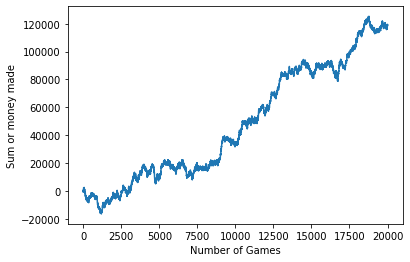

In [0]:
import matplotlib.pyplot as plt
import numpy as np
track = len(log[1])
wander = 0
y = np.zeros(track)
# wander keeps track of the agents net profit. y keeps track of the reward for each game
for i in range(0, track):
  wander += log[1][i]
  y[i] = wander
print(wander)

# This plot shows the net profit made over the number of games
x = np.linspace(0, track, track)
plt.plot()
plt.plot(x, y[0:track])
plt.xlabel("Number of Games")
plt.ylabel("Sum or money made")
plt.show()

265


Text(0, 0.5, 'Bet made')

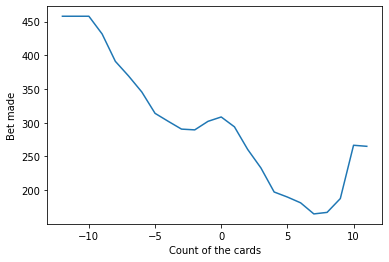

In [0]:
# max bet made by agent
max_count = max(log[2])
# min bet made
min_count = min(log[2])
plus_minus = max_count + abs(min_count) +1
num_count = np.zeros(plus_minus)
num_num_count = np.zeros(plus_minus)
# num_count is indexed by the count of the cards for each game. At each index you will find the sum total of all the bets made at that index
# num_num_count is indexed by the count of the cards for each game. At each index you will find the number of times a game was when the count was the index
for i in range(0, track):
  if log[2][i] == 11: print(log[0][i])
  num_count[log[2][i]+abs(min_count)] = num_count[log[2][i]+abs(min_count)] + abs(log[0][i])
  num_num_count[log[2][i]+abs(min_count)] = num_num_count[log[2][i]+abs(min_count)] + 1

avg_count = np.zeros(plus_minus)
# avg_count tracks the average bet made at each count.
for i in range(0, plus_minus):
  if num_num_count[i] != 0: avg_count[i] = num_count[i]/ num_num_count[i]
  else: avg_count[i] = 0

# This plot shows the average bet based on what the count of the cards was
h = np.linspace(min_count, max_count, plus_minus)
plt.plot(h, avg_count[0:plus_minus])
plt.xlabel("Count of the cards")
plt.ylabel("Bet made")

[481.         384.67114094 464.4375     301.01111111 303.42744063
 314.93908629 320.8680203  284.36294416 304.30310263 293.93646409
 300.31099196 293.88802083 282.48110831 259.79572447 264.23755656
 263.98879552 255.46153846 267.72658228 259.82903981 243.10772834
 248.61463415 256.96022727 242.54390935 231.73521851 234.25
 255.64439141 259.99459459 259.76519337 246.85087719 253.98963731
 259.63111111 265.19187359 275.4800995  255.57446809 244.29829545
 258.78       270.40657084 283.33808554 279.77030812 271.62931034
 274.3814433  275.72860125 283.86792453 280.39731286 267.06829268
 273.13684211 284.98253275 294.18617021 293.94641704          nan
          nan          nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Text(0, 0.5, 'Bet made')

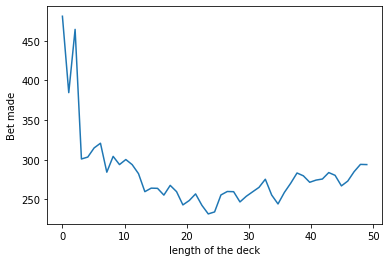

In [0]:
deck_length = np.zeros(52)
num_deck_length = np.zeros(52)
# deck_length tracks the total sum of bets made indexed by the length of the deck at that time.
# num_deck_length track the number of times a bet made at that index occured
for i in range(0, track):
  deck_length[log[3][i]] = deck_length[log[3][i]] + log[0][i]
  num_deck_length[log[3][i]] = num_deck_length[log[3][i]] + 1

# deck_avg tracks the avg bet made at the length of the deck
deck_avg = np.zeros(52)
for i in range(0, 52):
  deck_avg[i] = deck_length[i]/num_deck_length[i]

# Plots the bet made by the length of the deck
e = np.linspace(0, 52, 52)
plt.plot(e, deck_avg[0:52])
plt.xlabel("length of the deck")
plt.ylabel("Bet made")

In [0]:
# Tracks the average bet the agent makes
av_bet = 0
for i in range(0, track):
  av_bet += log[0][i]

print(av_bet/track)

283.41255


In [0]:
# Mr. Kyle King. 2020 March 6-7.Assistance given to the author, verbal discussion and electronic copying.
# https://gist.github.com/kylekyle/ba1d0d716b644e83495e95d68418167a Using this code and 
# verabl discussion Mr. King helped me understand how to use a reinforcement learning model
# and create an agent.

In [0]:
# Mr. Matthias Plappert. 2020 March 6. Electronic copying. https://github.com/keras-rl/keras-rl
# I used Keras-rl for this project and the example dqn_cartpole.py to understand how to import
# Keras featurs and compile my blackjack agent.

In [0]:
# Open AI gym contributers. 2020 March 6. Electronic copying. https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
# I modyfied the code from blackjack.py as my agent. Most of the methods from blackjack.py remain unchanged from the source.